## Import Libs

In [1]:
import os,sys
# deepspeech path
current_directory = os.path.dirname('/scratch/f006pq6/projects/gitrepos/deepspeech.pytorch/')  # If running from a script
sys.path.append(current_directory)
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

import torch
import torch.nn as nn
import hydra


from hydra.core.config_store import ConfigStore
from deepspeech_pytorch.configs.inference_config import EvalConfig
from deepspeech_pytorch.loader.data_loader import SpectrogramDataset, AudioDataLoader
from deepspeech_pytorch.utils import load_model, load_decoder
from deepspeech_pytorch.validation import run_evaluation
from deepspeech_pytorch.model import DeepSpeech, SequenceWise

from utils import *

from ctc_loss_imp import ctc_loss_imp
import matplotlib
%matplotlib inline



In [2]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(161,1024)
        self.fc2 = nn.Linear(1024, 29)
        self.seq = SequenceWise(nn.Sequential(self.fc1, nn.ReLU(), self.fc2))
    def forward(self,x):
        #torch.Size([1, 1, 161, 20])
        n,c,h,t = x.shape
        x = x.permute(3,0,1,2) # tnch
        x = x.reshape(t,n, c*h)
        x = self.seq(x) # t,n,-1
        x = x.permute(1,0,2) # n,-1,t

        return x
model_simple = SimpleModel().cuda()

In [3]:
# ------------------------------------------------------------------------------
# Config 
# ------------------------------------------------------------------------------
cs = ConfigStore.instance()
cs.store(name="config", node=EvalConfig)

cfg = EvalConfig()

# set bs = 1, device
cfg.batch_size=1
device = torch.device("cuda" if cfg.model.cuda else "cpu")


# ------------------------------------------------------------------------------
# Model
# ------------------------------------------------------------------------------
model_path='/scratch/f006pq6/projects/gitrepos/deepspeech.pytorch/librispeech_pretrained_v3.ckpt'
model_path='/scratch/f006pq6/projects/gitrepos/deepspeech.pytorch/outputs/2023-11-01/23-31-50/lightning_logs/version_0/checkpoints/epoch=5-step=19295.ckpt'
model_ds = DeepSpeech.load_from_checkpoint(model_path)
model_ds.train()
model_ds = model_ds.to(device)

# ------------------------------------------------------------------------------
# Data
# ------------------------------------------------------------------------------

test_dir = '/scratch/f006pq6/datasets/librispeech/test_clean'
test_dataset = SpectrogramDataset(
    audio_conf=model_ds.spect_cfg,
    input_path=hydra.utils.to_absolute_path(test_dir),
    labels=model_ds.labels,
    normalize=True
)
test_loader = AudioDataLoader(
    test_dataset,
    batch_size=cfg.batch_size,
    num_workers=cfg.num_workers
)
# ------------------------------------------------------------------------------
# Get an Input
# ------------------------------------------------------------------------------


inputs, targets, input_percentages, target_sizes = next(iter(test_loader)) 
inputs = inputs.to(device)


# # ==============================================================================
# # Make the input a bit smaller

inputs = inputs[:,:,:,-60:-40] # do 100 frames only
input_percentages[0] = 1.0
input_sizes = input_percentages.mul_(int(inputs.size(3))).int()
input_percentages = input_percentages.to(device)

print(inputs.shape)

torch.Size([1, 1, 161, 20])


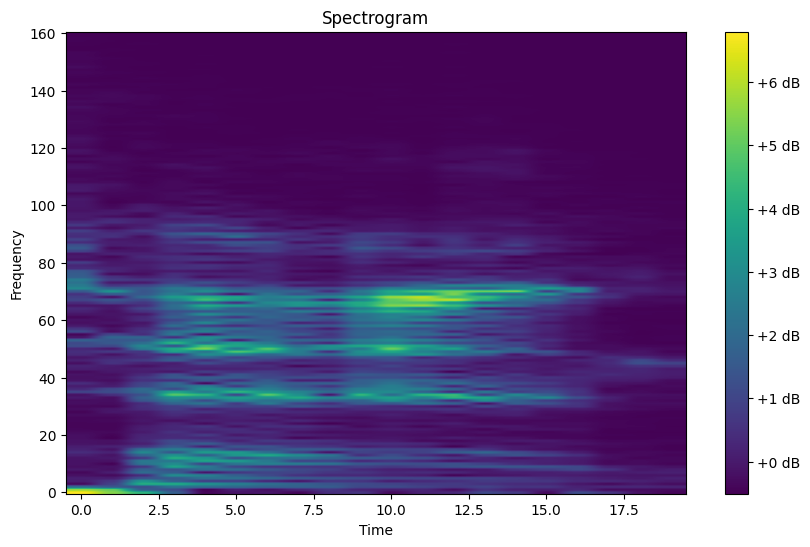

In [4]:
plot_spectrogram(inputs.detach())

In [17]:



# ------------------------------------------------------------------------------
#  Loss function, get target dL/dW
# ------------------------------------------------------------------------------
##get the param to match gradient
# weight_param = model_ds.fc[0].module[1].weight
weight_param = model_simple.fc2.weight

# out, output_sizes, hs = model_ds(inputs, input_sizes) # 1 176 29
out = model_simple(inputs) # 1 176 29

# ==============================================================================
# make target same length with inputs to use cross entr loss
targets = torch.randint(low=1, high=28, size = (1,out.shape[1])) .to(device)
target_sizes = torch.tensor(targets.shape[1]).to(device)


# ==============================================================================
# if ctc
# out = out.transpose(0, 1)  # TxNxH
# out = out.log_softmax(-1) # if model in train, use log_softmax. else use log
# from torch.nn import CTCLoss
# loss_ = CTCLoss(blank=model_ds.labels.index('_'), reduction='sum', zero_infinity=True)(out, targets, output_sizes, target_sizes)
# loss_func = lambda x,y :ctc_loss_imp(x, y, output_sizes, target_sizes,reduction='sum')

# ==============================================================================
# if crossentropy
out = out.squeeze()
targets = targets.squeeze()

# ==============================================================================
loss_func   = torch.nn.CrossEntropyLoss()
loss = loss_func(out, targets)
# print(loss.item(), loss_.item())
# grab gradient to match
dldw_target= torch.autograd.grad(loss, weight_param)[0]

print('grad shape:',dldw_target.shape, 'grad_norm', dldw_target.norm())


grad shape: torch.Size([29, 1024]) grad_norm tensor(2.9568, device='cuda:0')


In [12]:
targets.shape[0]

20

In [13]:
# ------------------------------------------------------------------------------
# Meta loss
# ------------------------------------------------------------------------------
def meta_loss(output, targets, output_sizes, target_sizes, dldw_target,  weight_param):
    loss = loss_func(output, targets)
    dldw = torch.autograd.grad(loss, weight_param, create_graph=True)[0]
    mse_loss = ((dldw-dldw_target)**2).sum()
    return mse_loss,dldw

# ------------------------------------------------------------------------------
# Init random input
# ------------------------------------------------------------------------------

x_hat = torch.nn.Parameter(torch.rand_like(inputs).to(device),requires_grad=True)

In [14]:
# ------------------------------------------------------------------------------
# Train
# ------------------------------------------------------------------------------
import torch.optim as optim

optimizer = optim.Adam([x_hat], lr=1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=.5,patience=100)

i=0
loss_history = []
while True:

    output = model_simple(x_hat) # 1 176 29
    # output, output_sizes, _= model_ds(x_hat, input_sizes) # 1 176 29
    # ==============================================================================
    # if crossentropy
    output = output.squeeze()

    # ==============================================================================
    # if ctc
    # output = output.transpose(0, 1)  # TxNxH
    # output = output.log_softmax() # if in training mode
    # output = output.log() # if in eval mode (deepspeech model already output softmax)

    # mloss, dldw_f = meta_loss(output, targets, output_sizes, target_sizes, dldw_target,  weight_param)
    mloss, dldw_f = meta_loss(output, targets, None, None, dldw_target,  weight_param)

    # add L2 regularization
    mloss += .001 * torch.sum(x_hat**2) 

    optimizer.zero_grad()
    mloss.backward()
    grad = x_hat.grad.data

    optimizer.step()

    loss_history.append(mloss.item())

    if i % 10 == 0:
        print('Iteration, Loss, Gradient Norm, Learning Rate: {:4d}, {:.4f}, {:.4f}, {:.4f}'.format(i, mloss.item(), grad.norm().item(), optimizer.param_groups[0]["lr"]))
        scheduler.step(mloss.item())

    if (i+ 1) % 10000 == 0:
        torch.save({
            'model':model_ds.state_dict(),
            'loss_history': loss_history,
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
             }, f'model_checkpoint_{i+ 1}.pt')
        print(f'Model saved at iteration {i+ 1}')


    i+=1

Iteration, Loss, Gradient Norm, Learning Rate:    0, 9.3334, 0.3000, 1.0000
Iteration, Loss, Gradient Norm, Learning Rate:   10, 3.7779, 0.1485, 1.0000
Iteration, Loss, Gradient Norm, Learning Rate:   20, 2.9651, 0.0822, 1.0000
Iteration, Loss, Gradient Norm, Learning Rate:   30, 2.6729, 0.0496, 1.0000
Iteration, Loss, Gradient Norm, Learning Rate:   40, 2.5676, 0.0306, 1.0000
Iteration, Loss, Gradient Norm, Learning Rate:   50, 2.5264, 0.0196, 1.0000
Iteration, Loss, Gradient Norm, Learning Rate:   60, 2.5106, 0.0127, 1.0000
Iteration, Loss, Gradient Norm, Learning Rate:   70, 2.5043, 0.0085, 1.0000
Iteration, Loss, Gradient Norm, Learning Rate:   80, 2.5021, 0.0063, 1.0000
Iteration, Loss, Gradient Norm, Learning Rate:   90, 2.5013, 0.0053, 1.0000
Iteration, Loss, Gradient Norm, Learning Rate:  100, 2.5011, 0.0049, 1.0000
Iteration, Loss, Gradient Norm, Learning Rate:  110, 2.5011, 0.0050, 1.0000
Iteration, Loss, Gradient Norm, Learning Rate:  120, 2.5010, 0.0051, 1.0000
Iteration, L

KeyboardInterrupt: 

## Plot sth

In [15]:
%matplotlib inline

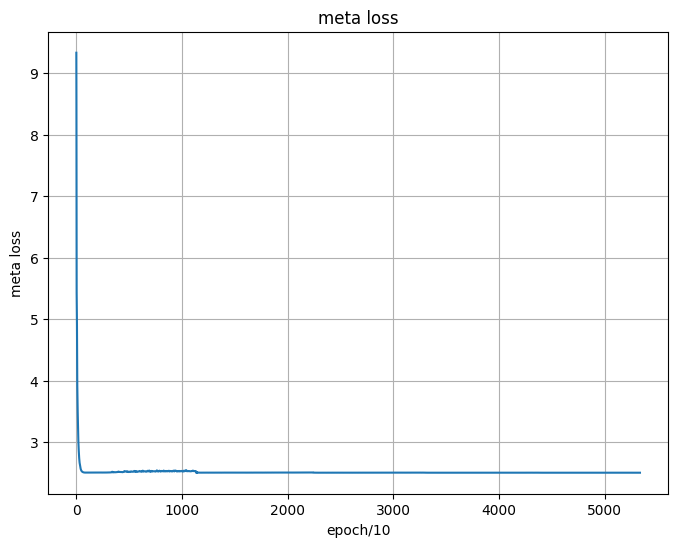

In [16]:
plot_loss_over_epoch(loss_history, 'meta loss','epoch/10','meta loss')

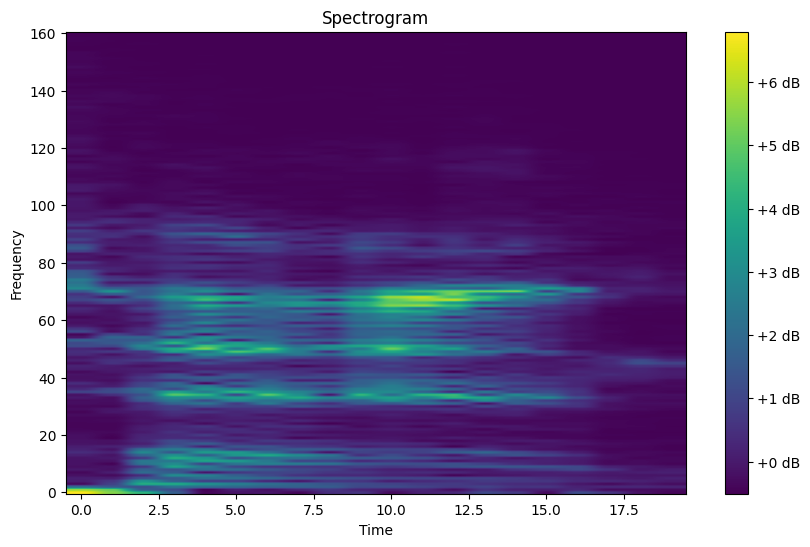

In [17]:
plot_spectrogram(inputs.detach())

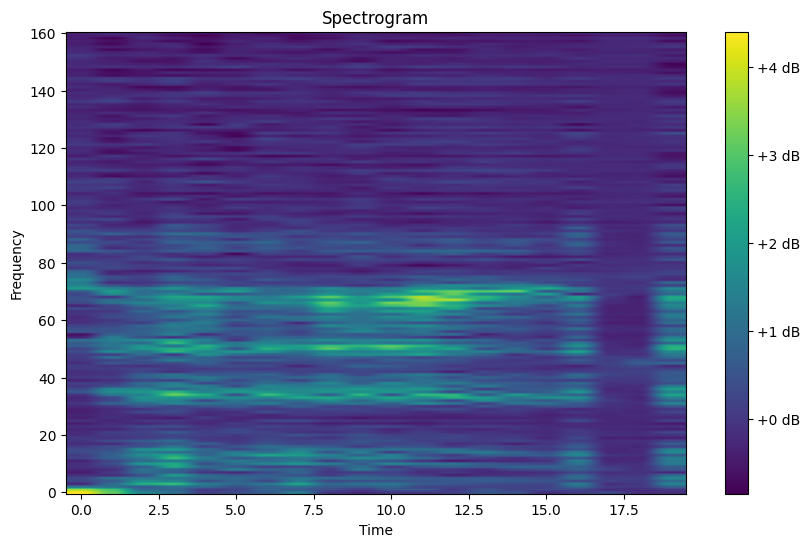

In [18]:
plot_spectrogram(x_hat.detach())

In [12]:
#pytorch 2nd order derivative test 
f = lambda x: x**3 + 2*x**2 - 3*x + 1
x = torch.tensor(1.0, requires_grad=True)

z = f(x)
y = z


dydx = torch.autograd.grad(y, x, create_graph=True)
d2ydx = torch.autograd.grad(dydx, x) # 10
print(dydx, d2ydx)

(tensor(4., grad_fn=<AddBackward0>),) (tensor(10.),)


In [15]:
inputs

tensor([[[[-0.3043, -0.4303, -0.3762,  ...,  0.5134,  1.7095,  2.8476],
          [-0.1027,  0.5423,  0.4987,  ...,  0.6480,  0.7588,  1.8047],
          [ 2.0492,  1.8057,  0.5868,  ..., -0.2155, -0.4123,  0.1292],
          ...,
          [-0.5023, -0.5069, -0.5051,  ..., -0.5088, -0.5086, -0.5027],
          [-0.4878, -0.4942, -0.5019,  ..., -0.5002, -0.5069, -0.5045],
          [-0.4990, -0.5016, -0.4991,  ..., -0.5022, -0.5019, -0.4977]]]],
       device='cuda:0')

In [14]:
x_hat

Parameter containing:
tensor([[[[-0.1900, -0.2737, -0.2501,  ..., -0.2592, -0.2041,  0.0140],
          [-0.0889, -0.2980, -0.2423,  ..., -0.0524, -0.1539,  0.0339],
          [-0.0138, -0.0941, -0.2136,  ...,  0.2180,  0.0822,  0.1171],
          ...,
          [-0.0406,  0.0202,  0.0043,  ..., -0.1420, -0.1500, -0.1585],
          [ 0.0349, -0.0315, -0.0175,  ..., -0.1832, -0.0994, -0.1352],
          [-0.0318, -0.0050, -0.0319,  ..., -0.1332, -0.0814, -0.0823]]]],
       device='cuda:0', requires_grad=True)